## Get Data

In [4]:
%load_ext autoreload
%autoreload 2
import os, sys


import pandas as pd
import numpy as np
import plotly
from preprocessing.data_processing import process_data, clean_data, cluster_rental_location, generate_features, bin_values

import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
pd.options.plotting.backend = "plotly"

DATA_DIR = './data'
train = os.path.join(DATA_DIR, 'train.csv')
test = os.path.join(DATA_DIR, 'test.csv')

train_final = os.path.join(DATA_DIR, 'train_with_mrt_mall_school_stock.csv')
test_final = os.path.join(DATA_DIR, 'test_with_mrt_mall_school_stock.csv')
train_final_df, test_final_df = pd.read_csv(train_final), pd.read_csv(test_final)
train_df, test_df = pd.read_csv(train), pd.read_csv(test)

train_df_cleaned, test_df_cleaned = clean_data(train_df), clean_data(test_df)
train_df_cleaned, test_df_cleaned = process_data(train_df_cleaned), process_data(test_df_cleaned, mode='test')
train_df_cleaned_final, test_df_cleaned_final = clean_data(train_final_df), clean_data(train_final_df)
train_df_cleaned_final, test_df_cleaned_final = process_data(train_df_cleaned_final), process_data(test_df_cleaned_final, mode='test')

train_df_cleaned, test_df_cleaned = generate_features(train_df_cleaned, test_df_cleaned)
train_df_cleaned_final, test_df_cleaned_final = generate_features(train_df_cleaned_final, test_df_cleaned_final)

## Price over time (Date only)

In [6]:
trained_df_group_avg = train_df_cleaned.groupby('rent_approval_date').mean(numeric_only=True).reset_index()
trained_df_group_avg.plot.line(x='rent_approval_date', y='monthly_rent', title='time vs. rental price', width=800, height=500)

In [ ]:
trained_df_group_avg = train_df_cleaned.groupby('rent_approval_date').mean(numeric_only=True).reset_index()
trained_df_group_avg.plot.line(x='rent_approval_date', y='psqm', title='time vs. per-square-meter price', width=800, height=500)

## Price overtime

In [ ]:
def plot_psqm_trend(df, target_attr):
  df = df.copy()
  trained_df_group_avg = df.groupby(['rent_approval_date', target_attr]).mean(numeric_only=True).reset_index()
  return trained_df_group_avg.pivot(index='rent_approval_date', columns=target_attr, values='psqm').plot.line(title=f'{target_attr} per squre meter price', width=800, height=500)

### Regional

In [ ]:
plot_psqm_trend(train_df_cleaned, 'region').show()

### Town Level

In [ ]:
plot_psqm_trend(train_df_cleaned, 'town').show()

### Planning Area

In [ ]:
plot_psqm_trend(train_df_cleaned, 'planning_area').show()

## Price with MRT station

In [ ]:
train_df_cleaned_final.plot.scatter(x='nearest_mrt_dist', y='psqm')

Apparently, there is no clear trend here. This is because by the analysis above, price is increasing along with date. Hence we need to break down more.

We need to constrain the date, and region/town to see whether we can observe a trend. 

In [ ]:
train_df_cleaned_final['mrt_distance_bin'] = bin_values(train_df_cleaned_final['nearest_mrt_dist'], step_size=0.2, right_bound=1.8, transformation_function=lambda x: 1.5 * x)
plot_psqm_trend(train_df_cleaned_final, 'mrt_distance_bin')

In [ ]:
train_df_cleaned_final['mrt_count_bin'] = bin_values(train_df_cleaned_final['near_mrt_count'], step_size=2, right_bound=10, transformation_function=lambda x:  x)
plot_psqm_trend(train_df_cleaned_final, 'mrt_count_bin')

After apply binning to the data, it's more clear that the longer the distance, the lower the price is

## Price with shopping mall

From the previous analysis, we need to analyse the distance bin with the per-square-meter price

In [ ]:
train_df_cleaned_final['mall_distance_bin'] = bin_values(train_df_cleaned_final['nearest_mall_dist'], step_size=0.5, right_bound=2, transformation_function=lambda x: x)
plot_psqm_trend(train_df_cleaned_final, 'mall_distance_bin')

In [ ]:
train_df_cleaned_final['mall_count_bin'] = bin_values(train_df_cleaned_final['near_mall_count'], step_size=2, right_bound=10, transformation_function=lambda x: x)
plot_psqm_trend(train_df_cleaned_final, 'mall_count_bin')

## Price with school

In [ ]:
train_df_cleaned_final['school_distance_bin'] = bin_values(train_df_cleaned_final['nearest_school_dist'], step_size=0.5, right_bound=2, transformation_function=lambda x: x)
plot_psqm_trend(train_df_cleaned_final, 'school_distance_bin')

In [ ]:
train_df_cleaned_final['school_count_bin'] = bin_values(train_df_cleaned_final['near_school_count'], step_size=2, right_bound=10, transformation_function=lambda x: x)
plot_psqm_trend(train_df_cleaned_final, 'school_count_bin')

## Price with age

In [ ]:
train_df_cleaned_final['age_year'] = train_df_cleaned_final['age'] / 360
train_df_cleaned_final['age_bin'] = bin_values(train_df_cleaned_final['age_year'], step_size=5, right_bound=30, transformation_function=lambda x: 1.5*x)
plot_psqm_trend(train_df_cleaned_final, 'age_bin')

## Price with Stock price

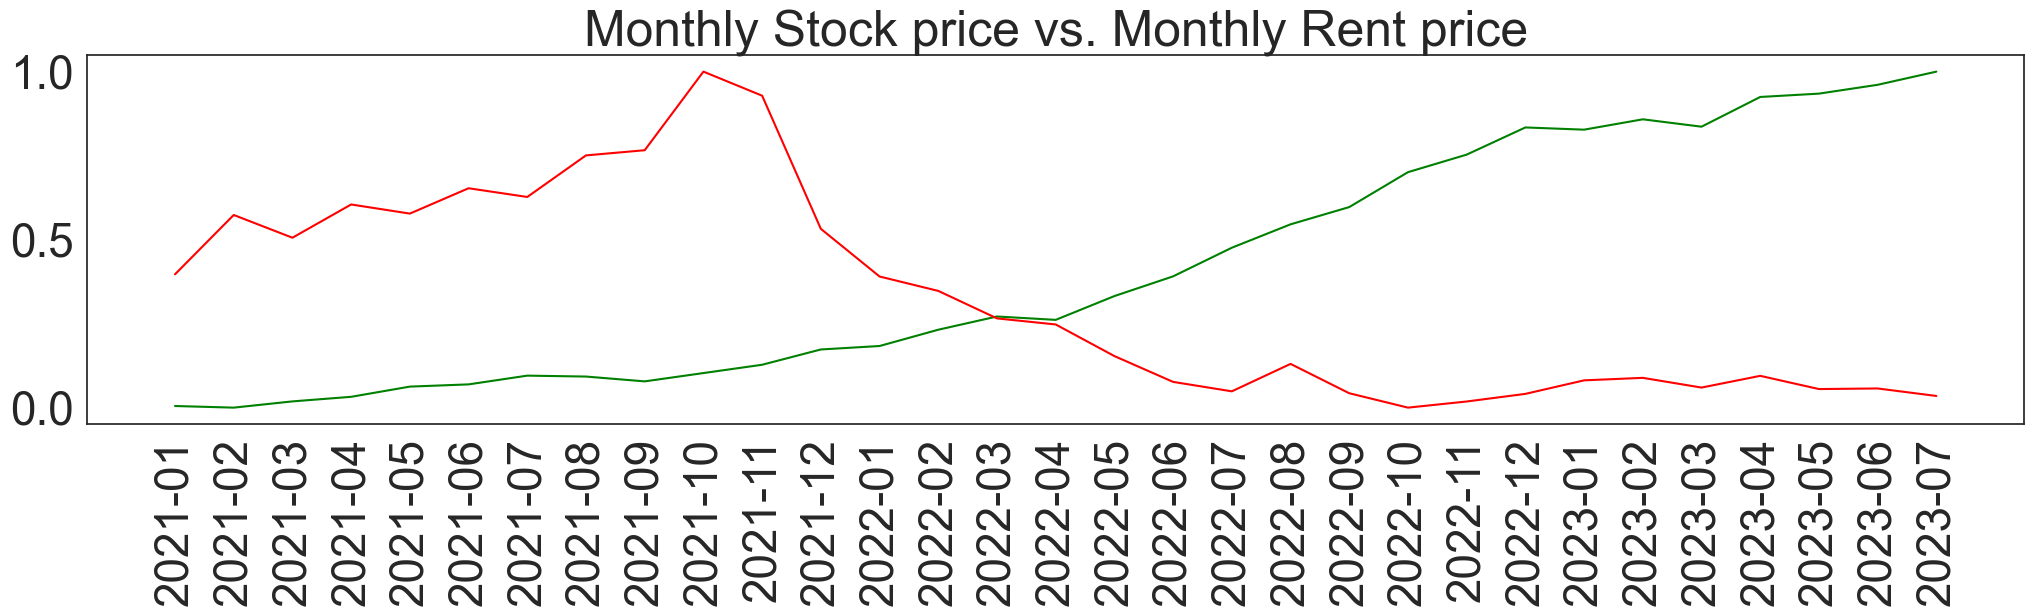

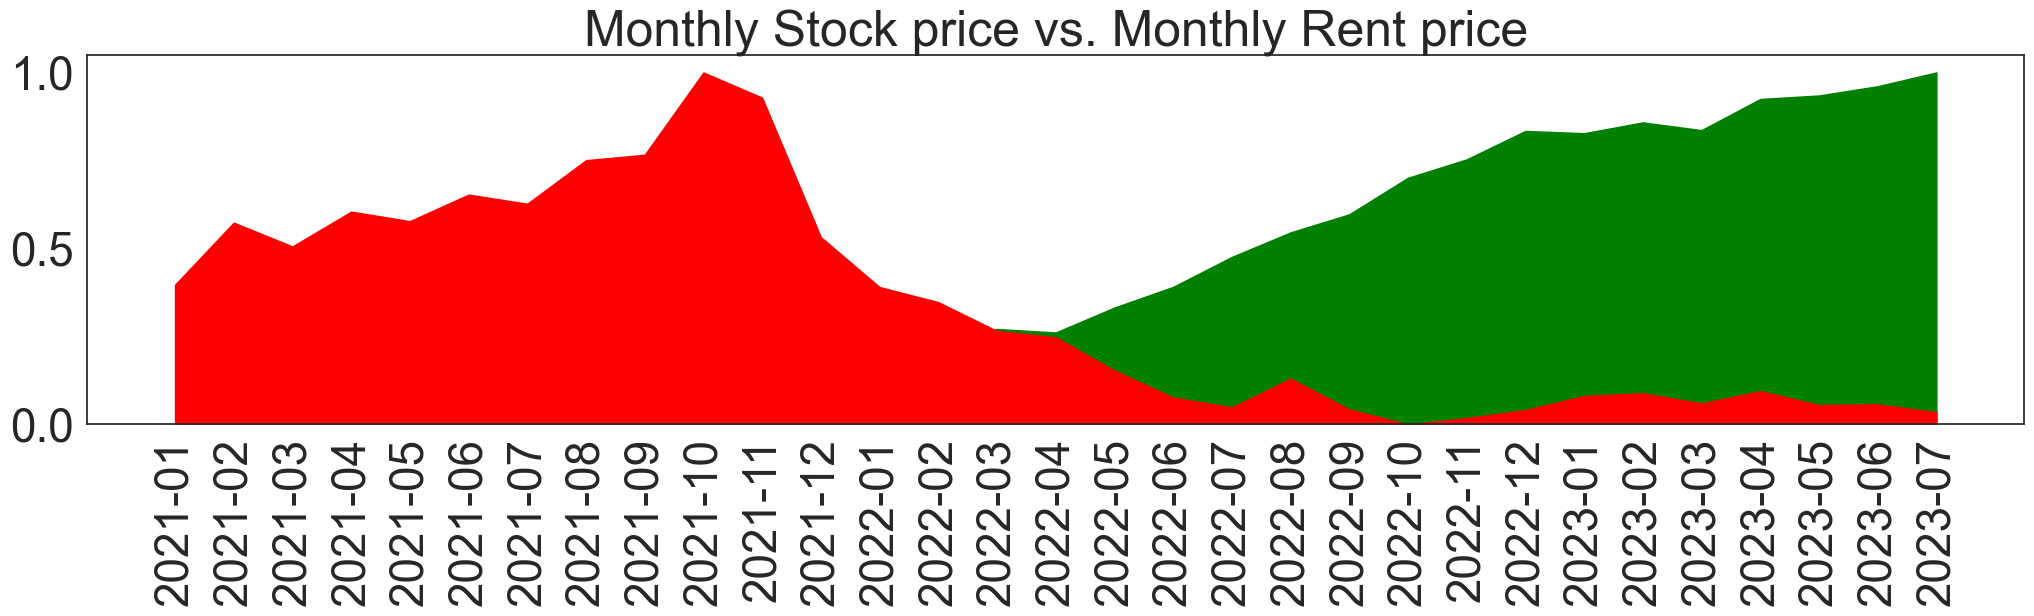

In [86]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scale = preprocessing.MinMaxScaler()
plt.figure().set_figwidth(25)
monthly_prices = train_df_cleaned_final.groupby('rent_approval_date').mean(numeric_only=True).reset_index()
monthly_prices_normalize = monthly_prices[["rent_approval_date","monthly_rent", "stock_price"]]
scaler = preprocessing.MinMaxScaler()
monthly_prices_normalize.iloc[:,1:] = scaler.fit_transform(monthly_prices_normalize.iloc[:,1:].to_numpy())
# print(monthly_prices_2)
plt.plot(monthly_prices_normalize['rent_approval_date'], monthly_prices_normalize['monthly_rent'], color='green')
plt.plot(monthly_prices_normalize['rent_approval_date'], monthly_prices_normalize['stock_price'], color='red')
plt.xticks(rotation=90)
plt.title("Monthly Stock price vs. Monthly Rent price") 
plt.show()
plt.figure().set_figwidth(25)
plt.stackplot(monthly_prices_normalize['rent_approval_date'], monthly_prices_normalize['monthly_rent'], color='green')
plt.stackplot(monthly_prices_normalize['rent_approval_date'], monthly_prices_normalize['stock_price'], color='red')
plt.xticks(rotation=90)
plt.title("Monthly Stock price vs. Monthly Rent price") 
plt.show()

## Summary - v1

From the analysis above, we are able to see that:

1. MRT has a clear correlation with price. The closer the distance, the higher the price. The more count, the higher the price and vice versa. 
2. The shopping mall and school is not so clear about the trend with unit price. The pattern exists but not so obvious, this is because Singapore has a lot small mall and school. To utilize this information, we might need to have more insight about popular school and popular mall. Probably by analysing the average percentile of price centered from a certain mall or school. Then we will know which school/mall is important.
3. Stock prices trend inversely proportional to rent prices. That is, the higher the rent price, the lower the stock price, and vice versa. 